In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
image_path = "./pizza_steak_sushi"
train_dir = image_path + "/train"
test_dir = image_path + "/test"

In [4]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224
# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [5]:
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [6]:
train_dir,test_dir

('./pizza_steak_sushi/train', './pizza_steak_sushi/test')

In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f74edae67f0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

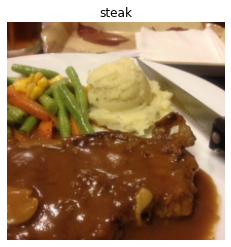

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [10]:
from transformer import Vit_Config

In [11]:
vit_model_args = dict(num_classes=len(class_names))

In [12]:
vit_config = Vit_Config(**vit_model_args)

In [13]:
vit_config

Vit_Config(img_size=224, in_channels=3, patch_size=16, num_transformer_layers=12, embed_size=768, inner_ff_size=3072, n_heads=12, attn_dropout=0, dropout=0.1, embedding_dropout=0.1, num_classes=3, activation='gelu')

In [14]:
from transformer import Vision_Transformer

In [15]:
vit = Vision_Transformer(vit_config)

In [16]:
random_image_tensor = torch.randn(1, 3, 224, 224)
vit(random_image_tensor)

tensor([[ 1.2084, -0.1298,  0.6675]], grad_fn=<AddmmBackward0>)

In [18]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
Vision_Transformer (Vision_Transformer)                 [32, 3, 224, 224]    [32, 3]              152,064              True
├─ModuleDict (vit_transformer)                          --                   --                   --                   True
│    └─PatchEmbedding (patch_embedding)                 [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    │    └─Conv2d (patcher)                            [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    │    └─Flatten (flatten)                           [32, 768, 14, 14]    [32, 768, 196]       --                   --
│    └─Dropout (embedding_dropout)                      [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (transformer_encoder)                 [32, 197, 768]       [32, 197, 768]       --                   True
│    │ 

In [19]:
from super_repo import data_setup, engine, utils
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=2,
                       device=device)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7905 | train_acc: 0.4336 | test_loss: 4.3192 | test_acc: 0.1979
Epoch: 2 | train_loss: 2.0160 | train_acc: 0.2812 | test_loss: 1.1449 | test_acc: 0.1979


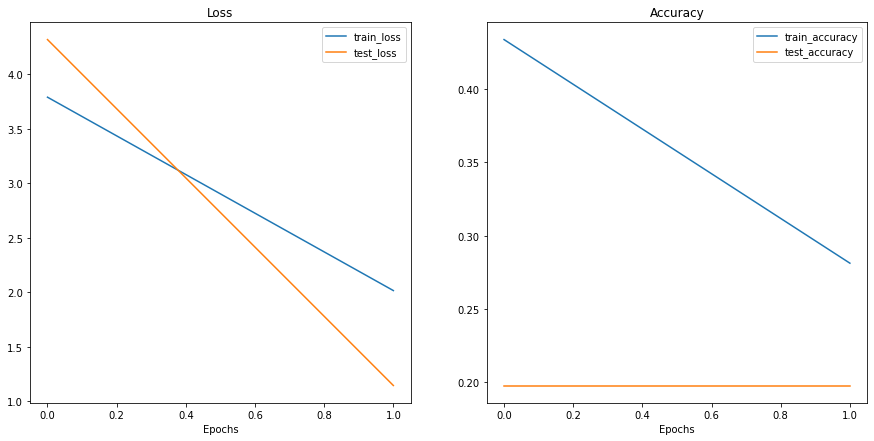

In [20]:
from super_repo.utils import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)